# Fama and French Factor Model #

### Import Data ###

In [73]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from functions import import_stock_universe
from capm_toolkit import compute_daily_returns
from capm_toolkit import compute_excess_returns
from capm_toolkit import capm_regression
from portfolios_toolkit import calculate_analytics

In [3]:
# Get the important data for the Risk Free Rate

rfr = pd.read_csv(r"..\additional_data\rfr.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index, dayfirst=True)

# Get the important data for the S&P500

sp500 = pd.read_csv(r"..\additional_data\sp500.csv")
sp500 = sp500.set_index('Date')
sp500.index = pd.to_datetime(sp500.index)

# Get the data for the Stocks' Betas

betas_df = pd.read_csv(r"..\additional_data\capm_hbetas.csv")
betas_df = betas_df.set_index('date')
betas_df.index = pd.to_datetime(betas_df.index)

In [4]:
# Dictionary to store the DataFrames
folder_path = r"..\stocks"

dataframes = import_stock_universe(
    folder_path,
    ['Adjusted_close', 'Company Market Cap', 'Price_to_Book'],
    ['adj_close', 'mkt_cap', 'ptb'],
)

File loaded: A (2472 rows)
File loaded: AAPL (2472 rows)
File loaded: ABBV (2472 rows)
File skipped (less than 2000 rows after cleaning): ABNB.csv
File loaded: ABT (2472 rows)
File loaded: ADBE (2472 rows)
File loaded: ADI (2472 rows)
File loaded: ADM (2472 rows)
File loaded: ADP (2472 rows)
File loaded: ADSK (2472 rows)
File loaded: AEE (2472 rows)
File loaded: AEP (2472 rows)
File loaded: AES (2472 rows)
File loaded: AFL (2472 rows)
File loaded: AIG (2472 rows)
File loaded: AIZ (2472 rows)
File loaded: AJG (2472 rows)
File loaded: AKAM (2472 rows)
File loaded: ALB (2472 rows)
File loaded: ALGN (2472 rows)
File loaded: ALL (2472 rows)
File loaded: AMAT (2472 rows)
File loaded: AMD (2472 rows)
File loaded: AME (2472 rows)
File loaded: AMGN (2472 rows)
File loaded: AMP (2472 rows)
File loaded: AMT (2472 rows)
File loaded: AMZN (2472 rows)
File loaded: ANET (2472 rows)
File loaded: ANSS (2472 rows)
File loaded: AOS (2472 rows)
File loaded: APA (2472 rows)
File loaded: APD (2472 rows)
Fil

In [5]:
dataframes

{'A':             adj_close       mkt_cap       ptb
 Date                                         
 2015-01-02      40.56  1.361071e+10  2.488435
 2015-01-05      39.80  1.344976e+10  2.441807
 2015-01-06      39.18  1.326198e+10  2.403769
 2015-01-07      39.70  1.309767e+10  2.435672
 2015-01-08      40.89  1.274558e+10  2.508681
 ...               ...           ...       ...
 2024-10-22     133.46  3.779508e+10  6.807092
 2024-10-23     133.03  3.779508e+10  6.807092
 2024-10-24     130.69  3.779508e+10  6.807092
 2024-10-25     130.19  3.779508e+10  6.807092
 2024-10-28     131.54  3.779508e+10  6.807092
 
 [2472 rows x 3 columns],
 'AAPL':             adj_close       mkt_cap        ptb
 Date                                          
 2015-01-02    27.3325  6.524300e+11   5.749571
 2015-01-05    26.5625  6.363537e+11   5.587596
 2015-01-06    26.5650  6.420037e+11   5.588122
 2015-01-07    26.9375  6.395573e+11   5.666480
 2015-01-08    27.9725  6.221996e+11   5.884199
 ...        

In [6]:
# Create a whole new dataframe that contains all the stocks betas

rets_series = []

for stock, df in dataframes.items():
    series = df['adj_close'].pct_change(1).rename(stock)  
    series = series.iloc[1:]
    rets_series.append(series)

# Concat
returns_df = pd.concat(rets_series, axis=1)
returns_df = returns_df.apply(lambda x: x.fillna(x.mean()), axis=0)

returns_df.dropna(inplace = True)

returns_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.018738,-0.028172,-0.018819,0.000223,-0.004976,-0.018275,-0.034602,-0.000720,-0.014614,-0.010002,...,-0.013804,0.000000,-0.017020,-0.011351,-0.027362,-0.062237,-0.020318,0.037303,-0.014077,-0.006003
2015-01-06,-0.015578,0.000094,-0.004950,-0.011356,-0.020144,-0.023384,-0.019713,-0.008350,-0.019775,-0.011641,...,-0.017107,-0.001108,-0.021331,0.005321,-0.005316,-0.005881,-0.012274,-0.008477,-0.007205,-0.009756
2015-01-07,0.013272,0.014022,0.040417,0.008108,0.008223,0.010516,0.015031,0.008784,-0.002087,0.007778,...,0.016218,0.003050,0.029368,0.008635,0.010133,0.007887,0.033138,0.024870,0.025465,0.020643
2015-01-08,0.029975,0.038422,0.010459,0.020554,0.025383,0.017655,-0.014609,0.022940,0.024747,0.003528,...,0.019657,0.010779,0.012031,0.011599,0.016645,0.007546,0.017420,0.010617,0.021359,0.015399
2015-01-09,-0.007337,0.001072,-0.027355,-0.010508,-0.014743,-0.000730,-0.008530,-0.007162,-0.009014,-0.011206,...,-0.011453,-0.001367,0.012499,-0.012285,-0.001410,-0.018863,-0.001767,-0.014424,0.014613,0.001584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,-0.024130,-0.002622,0.011901,-0.007437,-0.009242,-0.004653,-0.007839,0.001478,-0.004486,-0.005327,...,-0.002959,-0.019820,0.010471,0.003941,0.005163,-0.008678,-0.004776,-0.008935,-0.001584,0.000317
2024-10-23,-0.003222,-0.021623,-0.004662,0.007664,-0.016386,0.009928,0.007003,-0.004462,-0.007574,0.016408,...,0.000140,0.006319,-0.017304,0.010050,-0.003563,0.002664,0.004949,0.004220,-0.010511,-0.002744
2024-10-24,-0.017590,-0.000823,0.009421,-0.004017,-0.004453,0.012475,0.007489,-0.002103,-0.001834,-0.002130,...,0.154343,0.008791,0.002252,0.012282,-0.005654,-0.008123,-0.006417,-0.006686,-0.016409,-0.039632


In [14]:
# Create a whole new dataframe that contains all the stocks betas
mktcap_series = []

for stock, df in dataframes.items():
    series = df['mkt_cap'].rename(stock)  
    mktcap_series.append(series)

# Concat
mktcap_df = pd.concat(mktcap_series, axis=1)

# Apply Logs and EMA (maybe)
mktcap_df = np.log(mktcap_df)
mktcap_df = mktcap_df.ewm(span=5, adjust = False).mean()
mktcap_df = mktcap_df.bfill()
mktcap_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,23.334123,27.203970,25.377155,24.943681,24.302035,23.559815,24.159956,24.431034,23.307838,23.113587,...,22.026376,23.674862,23.438370,23.629933,26.681463,22.658517,24.193312,23.719963,22.134555,23.801148
2015-01-05,23.330158,27.195653,25.370822,24.946472,24.298677,23.556447,24.155764,24.429394,23.302185,23.112251,...,22.026955,23.675318,23.437048,23.626971,26.674995,22.637097,24.190807,23.720752,22.135051,23.799141
2015-01-06,23.322827,27.193056,25.364946,24.941162,24.293945,23.550365,24.153454,24.427646,23.298706,23.114248,...,22.031174,23.676714,23.439184,23.627682,26.669463,22.620852,24.187762,23.722008,22.143062,23.794535
2015-01-07,23.313785,27.190051,25.374236,24.935147,24.287945,23.546062,24.146133,24.425507,23.290937,23.118662,...,22.028543,23.675366,23.437905,23.631093,26.664810,22.612640,24.184353,23.718410,22.143070,23.798275
2015-01-08,23.298673,27.178876,25.383898,24.928643,24.285371,23.538298,24.139563,24.423942,23.281595,23.124659,...,22.021584,23.673826,23.434914,23.636280,26.658798,22.609671,24.178091,23.709693,22.143280,23.805863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,24.359499,28.894991,26.534050,26.021293,26.084679,25.458613,24.026839,25.488614,24.844448,23.881938,...,23.826310,23.869559,23.115062,24.304214,26.996807,24.201920,24.353951,23.773377,23.657095,25.182539
2024-10-23,24.358148,28.895857,26.532027,26.018830,26.082683,25.459665,24.028783,25.487036,24.844284,23.881549,...,23.829513,23.869051,23.115454,24.304586,26.995484,24.197550,24.355530,23.773072,23.656280,25.179429
2024-10-24,24.357247,28.896433,26.533804,26.017188,26.081352,25.460366,24.030079,25.485985,24.844175,23.881290,...,23.831649,23.868712,23.115716,24.304834,26.994603,24.191917,24.356583,23.772869,23.655737,25.163876


In [19]:
# Create a whole new dataframe that contains all the stocks betas

ptb_series = []

for stock, df in dataframes.items():
    series = df['ptb'].rename(stock)  
    series = series.iloc[1:]
    ptb_series.append(series)

# Concat
ptb_df = pd.concat(ptb_series, axis=1)

# Apply an ema
ptb_df = ptb_df.ewm(span=5, adjust = False).mean()
ptb_df = ptb_df.bfill()

ptb_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,2.441807,5.587596,28.696895,2.930389,5.331714,3.578323,1.642816,6.475296,5.883338,1.630584,...,3.770110,2.997794,154.504537,1.777380,2.117182,3.053056,8.891170,3.148420,4.959165,15.818530
2015-01-06,2.429128,5.587772,28.649548,2.919297,5.295913,3.550431,1.632021,6.457272,5.844557,1.624257,...,3.748611,2.996687,153.405952,1.780533,2.113430,3.047071,8.854793,3.139524,4.947255,15.767087
2015-01-07,2.431309,5.614008,29.002679,2.919732,5.286366,3.544087,1.632893,6.464058,5.814691,1.624217,...,3.754312,2.998993,154.153798,1.787777,2.118042,3.051061,8.927548,3.159473,4.981108,15.840577
2015-01-08,2.457100,5.704072,29.341673,2.940032,5.324568,3.560640,1.625515,6.518115,5.842254,1.626101,...,3.782787,3.011322,155.276558,1.799575,2.132919,3.061416,9.028736,3.184095,5.039621,15.971632
2015-01-09,2.468159,5.766218,29.293942,2.943125,5.323493,3.570800,1.616016,6.538333,5.842910,1.621268,...,3.787112,3.018159,156.681362,1.799975,2.141821,3.048940,9.090759,3.184963,5.103749,16.067576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,6.807092,53.517088,49.251603,5.134883,15.028926,3.197555,1.203895,26.118882,25.100985,2.036131,...,8.136879,2.346543,-100.884750,1.973494,1.996984,3.135178,-4.926830,1.686979,5.856955,17.433270
2024-10-23,6.807092,53.230619,49.151179,5.135068,14.909995,3.198571,1.199981,26.088616,25.027364,2.044902,...,8.114685,2.333284,-100.276350,1.981214,1.994946,3.121444,-4.929797,1.685912,5.829634,17.379060
2024-10-24,6.807092,53.025187,49.237948,5.135191,14.808928,3.212557,1.200348,26.050193,24.963076,2.049286,...,8.313285,2.339605,-99.945119,1.994535,1.989836,3.103909,-4.921217,1.681449,5.779832,17.114765


In [21]:
# We prefer to use book to price
btp_df = 1 / ptb_df

btp_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,0.409533,0.178968,0.034847,0.341252,0.187557,0.279461,0.608711,0.154433,0.169972,0.613277,...,0.265244,0.333579,0.006472,0.562626,0.472326,0.327541,0.112471,0.317620,0.201647,0.063217
2015-01-06,0.411670,0.178962,0.034905,0.342548,0.188825,0.281656,0.612737,0.154864,0.171099,0.615666,...,0.266765,0.333702,0.006519,0.561630,0.473164,0.328184,0.112933,0.318520,0.202132,0.063423
2015-01-07,0.411301,0.178126,0.034480,0.342497,0.189166,0.282160,0.612410,0.154702,0.171978,0.615681,...,0.266360,0.333445,0.006487,0.559354,0.472134,0.327755,0.112013,0.316508,0.200759,0.063129
2015-01-08,0.406984,0.175313,0.034081,0.340132,0.187809,0.280848,0.615190,0.153419,0.171167,0.614968,...,0.264355,0.332080,0.006440,0.555687,0.468841,0.326646,0.110757,0.314061,0.198428,0.062611
2015-01-09,0.405160,0.173424,0.034137,0.339775,0.187847,0.280049,0.618806,0.152944,0.171148,0.616801,...,0.264053,0.331328,0.006382,0.555563,0.466892,0.327983,0.110002,0.313975,0.195934,0.062237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,0.146906,0.018686,0.020304,0.194746,0.066538,0.312739,0.830637,0.038286,0.039839,0.491128,...,0.122897,0.426159,-0.009912,0.506716,0.500755,0.318961,-0.202970,0.592776,0.170737,0.057362
2024-10-23,0.146906,0.018786,0.020345,0.194739,0.067069,0.312640,0.833346,0.038331,0.039956,0.489021,...,0.123233,0.428580,-0.009972,0.504741,0.501267,0.320365,-0.202848,0.593151,0.171537,0.057541
2024-10-24,0.146906,0.018859,0.020310,0.194735,0.067527,0.311279,0.833092,0.038387,0.040059,0.487975,...,0.120289,0.427423,-0.010005,0.501370,0.502554,0.322174,-0.203202,0.594725,0.173015,0.058429


In [45]:
# Create the data
daily_rfr = compute_daily_returns(rfr['risk_free_rate'])
market_excess_returns = compute_excess_returns(sp500['sp_500'], rfr['risk_free_rate'])

### Testing for Size Factor ###

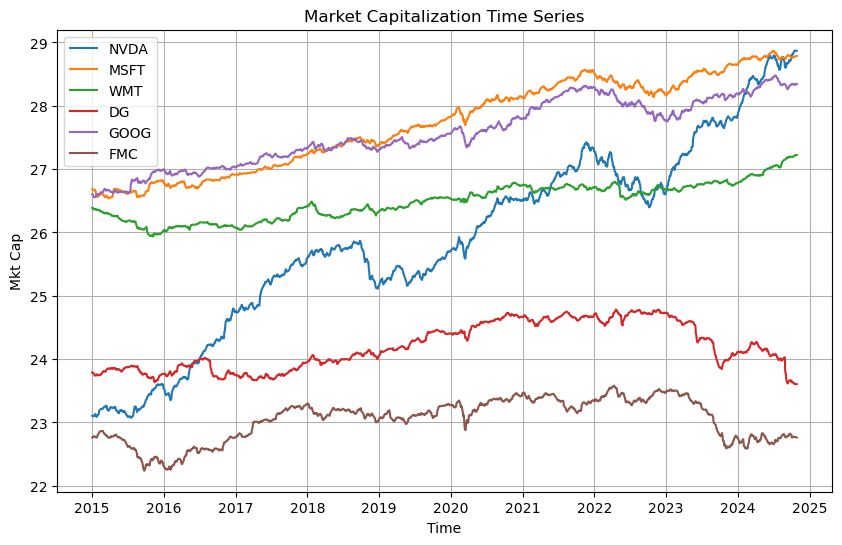

In [31]:
# Create Plot

tickers = ['NVDA', 'MSFT', 'WMT', 'DG', 'GOOG', 'FMC']

plt.figure(figsize=(10, 6))
plt.plot(mktcap_df[tickers], label=tickers, alpha=1)

# Config
plt.title('Market Capitalization Time Series')
plt.xlabel('Time')
plt.ylabel('Mkt Cap')
plt.legend()
plt.grid()

# Show
plt.show()

In [32]:
# Define the Decomposition Function
def size_decomposition(
    target_df, 
    mktcap_df
):
    # Common Indexes
    common_index = target_df.index.intersection(mktcap_df.index)
    
    # Reindex
    target_df = target_df.loc[common_index]
    mktcap_df = mktcap_df.loc[common_index]

    # Initialize lists to store portfolio returns
    big_list, mid_list, small_list = [], [], []
    
    # Get unique quarters
    quarters = sorted(set([date.to_period('Q') for date in common_index]))
    
    # Dictionary to store quarterly classifications and weights
    quarterly_classifications = {}

    for quarter in quarters:
        # Select only the last available date of the quarter
        quarter_dates = [date for date in common_index if date.to_period('Q') == quarter]
        rebalance_date = quarter_dates[-1]  # Last day of the quarter
        
        # Size factor for rebalance date
        size_factor_df = pd.DataFrame([mktcap_df.loc[rebalance_date]], index=['mkt_cap']).T.dropna()
        
        # Classify stocks into based on the median
        median = size_factor_df['mkt_cap'].median()

        size_factor_df['Size_Class'] = 'Small'
        size_factor_df.loc[size_factor_df['mkt_cap'] > median, 'Size_Class'] = 'Big'
        
        # Weights
        market_caps_df = pd.DataFrame([mktcap_df.loc[rebalance_date]], index=['mkt_cap']).T
        
        # Assign market caps to value classes
        small_mktcap_df = market_caps_df.loc[size_factor_df[size_factor_df['Size_Class'] == 'Small'].index]
        big_mktcap_df = market_caps_df.loc[size_factor_df[size_factor_df['Size_Class'] == 'Big'].index]
        
        # Compute weights
        small_weights = small_mktcap_df['mkt_cap'] / small_mktcap_df['mkt_cap'].sum()
        big_weights = big_mktcap_df['mkt_cap'] / big_mktcap_df['mkt_cap'].sum()
        
        # Store classifications and weights
        quarterly_classifications[quarter] = {
            "small": small_weights,
            "big": big_weights
        }
    
    # Iterate over all available dates to compute daily returns
    for date in common_index:
        quarter_key = date.to_period('Q')  # Get quarter of the current date
        
        if quarter_key in quarterly_classifications:
            # Retrieve stored classification and weights
            small_weights = quarterly_classifications[quarter_key]["small"]
            big_weights = quarterly_classifications[quarter_key]["big"]
            
            # Retrieve daily returns
            target = pd.DataFrame([target_df.loc[date]], index=['returns']).T
            
            small_returns = target.reindex(small_weights.index).dropna()
            big_returns = target.reindex(big_weights.index).dropna()
            
            # Compute portfolio returns
            small_result = small_weights.reindex(small_returns.index).T @ small_returns
            big_result = big_weights.reindex(big_returns.index).T @ big_returns
            
            # Store results
            small_list.append(small_result.values[0] if not small_result.empty else None)
            big_list.append(big_result.values[0] if not big_result.empty else None)

    # Create final DataFrame
    size_portfolios = pd.DataFrame({
        'big': big_list,
        'small': small_list
    }, index=common_index)
    
    return size_portfolios

In [33]:
# Create DataFrames

size_portfolio_returns = size_decomposition(returns_df, mktcap_df)

size_portfolio_returns

,big,small
Date,,
2015-01-05,-0.016227,-0.016136
2015-01-06,-0.008269,-0.010690
2015-01-07,0.012730,0.012871
2015-01-08,0.017175,0.019287
2015-01-09,-0.008376,-0.006500
...,...,...
2024-10-22,-0.001832,-0.007347
2024-10-23,-0.004152,-0.002231
2024-10-24,-0.000871,0.001514


In [74]:
# Analytics Table

size_analytics_table = calculate_analytics(size_portfolio_returns)

size_analytics_table

,Annualized Returns,Annualized Volatility,Sharpe Ratio,Max Drawdown,VaR 95%
big,0.158644,0.171142,0.926978,-0.003752,-0.015747
small,0.132722,0.197262,0.672820,-0.005099,-0.017322


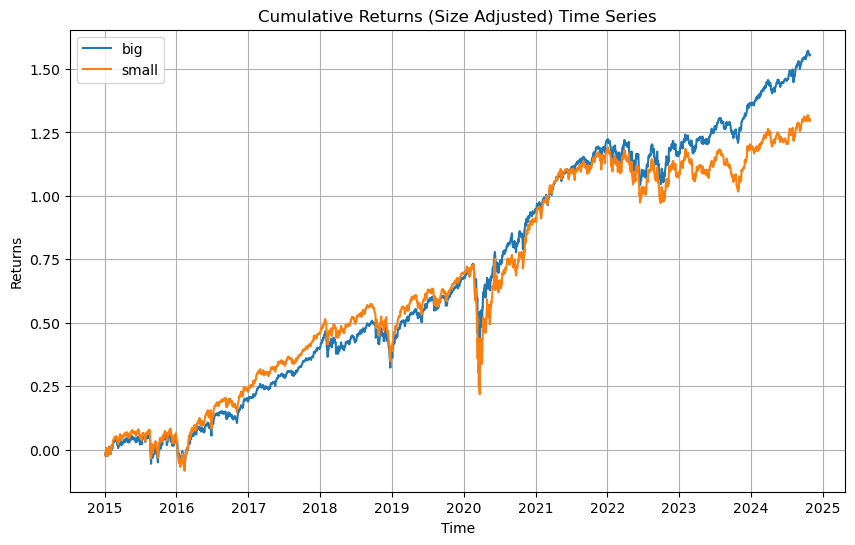

In [37]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(size_portfolio_returns.cumsum(), label=size_portfolio_returns.columns, alpha=1)

# Config
plt.title('Cumulative Returns (Size Adjusted) Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [38]:
# Create DataFrames

size_portfolio_betas = size_decomposition(betas_df, mktcap_df)

size_portfolio_betas

,big,small
2016-01-06,0.957622,0.984037
2016-01-07,0.962792,0.981627
2016-01-08,0.963218,0.981637
2016-01-11,0.962193,0.980965
2016-01-12,0.962245,0.975766
...,...,...
2024-10-21,0.767944,0.784805
2024-10-22,0.766041,0.781697
2024-10-23,0.762844,0.776026
2024-10-24,0.761751,0.774999


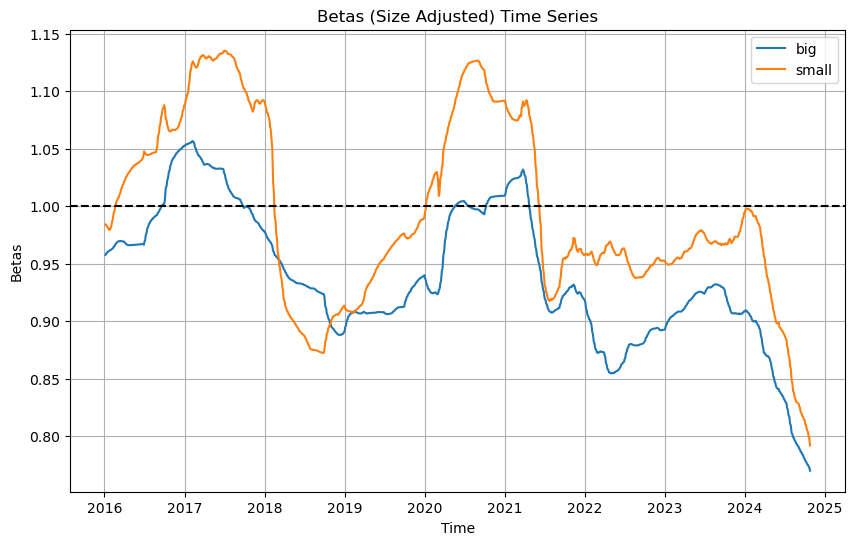

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(size_portfolio_betas.ewm(span=21, adjust = False).mean(), label=size_portfolio_betas.columns, alpha=1)
plt.axhline(y=1, color='black', linestyle='dashed')

# Config
plt.title('Betas (Size Adjusted) Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()
plt.grid()

# Show
plt.show()

In [46]:
# Create the regression dataframe
size_regression_df = pd.DataFrame(index = size_portfolio_returns.index)

size_regression_df['big_excess_returns'] = size_portfolio_returns['big'] - daily_rfr
size_regression_df['small_excess_returns'] = size_portfolio_returns['small'] - daily_rfr
size_regression_df['market_excess_returns'] = market_excess_returns
size_regression_df.dropna(inplace = True)

size_regression_df

,big_excess_returns,small_excess_returns,market_excess_returns
Date,,,
2015-01-05,-0.016283,-0.016192,-0.018334
2015-01-06,-0.008323,-0.010744,-0.008948
2015-01-07,0.012676,0.012817,0.011576
2015-01-08,0.017119,0.019231,0.017832
2015-01-09,-0.008430,-0.006555,-0.008458
...,...,...,...
2024-10-22,-0.001946,-0.007462,-0.000589
2024-10-23,-0.004268,-0.002347,-0.009307
2024-10-24,-0.000985,0.001399,0.002031


In [47]:
# Calculate the Beta for the Large Portfolio

y = size_regression_df['big_excess_returns']
x = size_regression_df['market_excess_returns']

# Calculate Weights
window = len(y) 
     
#the results of the model
results = capm_regression(
    y,
    x,
    window,
    True
)
    
#here we check the summary
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:     big_excess_returns   R-squared:                       0.952
Model:                            WLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                 4.827e+04
Date:                Mon, 21 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:14:28   Log-Likelihood:                 11243.
No. Observations:                2454   AIC:                        -2.248e+04
Df Residuals:                    2452   BIC:                        -2.247e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.00

In [48]:
# Calculate the Beta for the Small Portfolio

y = size_regression_df['small_excess_returns']
x = size_regression_df['market_excess_returns']

# Calculate Weights
window = len(y) 
     
#the results of the model
results = capm_regression(
    y,
    x,
    window,
    True
)
    
#here we check the summary
print(results.summary())

                             WLS Regression Results                             
Dep. Variable:     small_excess_returns   R-squared:                       0.837
Model:                              WLS   Adj. R-squared:                  0.837
Method:                   Least Squares   F-statistic:                 1.259e+04
Date:                  Mon, 21 Apr 2025   Prob (F-statistic):               0.00
Time:                          16:15:07   Log-Likelihood:                 9386.5
No. Observations:                  2454   AIC:                        -1.877e+04
Df Residuals:                      2452   BIC:                        -1.876e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const     

In [49]:
# Calculate the Small Minus Big Premium

size_regression_df['SMB'] = size_portfolio_returns['small'] - size_portfolio_returns['big']

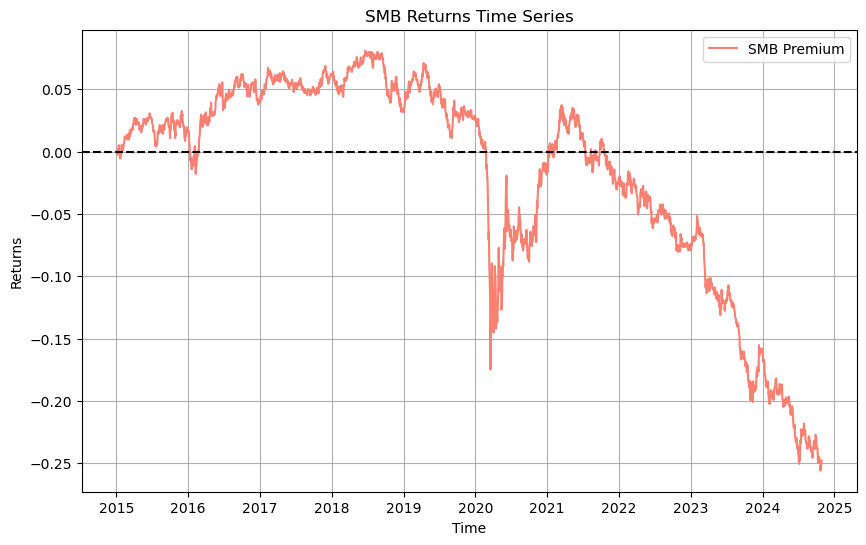

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(size_regression_df['SMB'].cumsum(), label='SMB Premium', color = 'salmon', alpha=1)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('SMB Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [51]:
# Check the Correlation with the Market

size_regression_df['SMB'].corr(size_regression_df['market_excess_returns'])

0.24182900620830186

In [52]:
# Calculate the Beta for the SMB Premium

y = size_regression_df['SMB']

x = size_regression_df['market_excess_returns']

# Calculate Weights
window = len(y) 
     
#the results of the model
results = capm_regression(
    y,
    x,
    window,
    True
)
    
#here we check the summary
print(results.summary())  

                            WLS Regression Results                            
Dep. Variable:                    SMB   R-squared:                       0.057
Model:                            WLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     149.6
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           1.98e-33
Time:                        16:15:57   Log-Likelihood:                 10113.
No. Observations:                2454   AIC:                        -2.022e+04
Df Residuals:                    2452   BIC:                        -2.021e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

### Testing for Value Factor ###

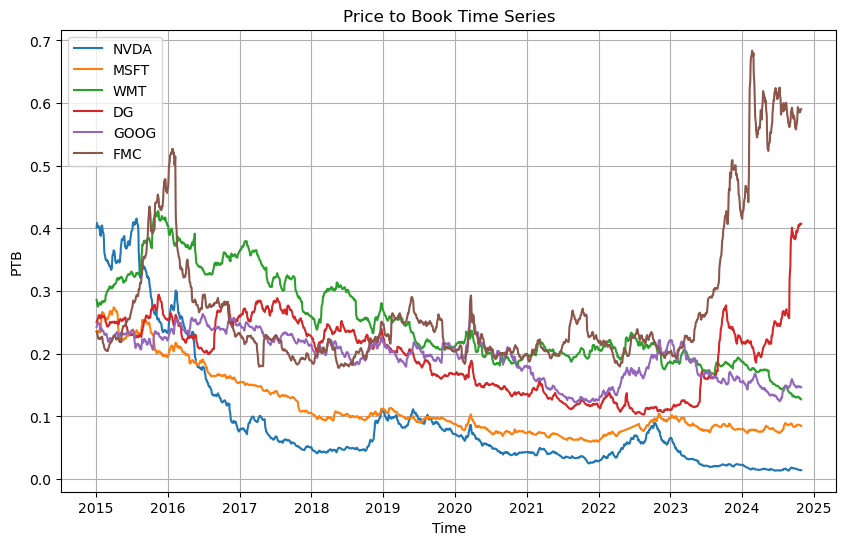

In [54]:
# Create Plot

tickers = ['NVDA', 'MSFT', 'WMT', 'DG', 'GOOG', 'FMC']

plt.figure(figsize=(10, 6))
plt.plot(btp_df[tickers], label=tickers, alpha=1)

# Config
plt.title('Price to Book Time Series')
plt.xlabel('Time')
plt.ylabel('PTB')
plt.legend()
plt.grid()

# Show
plt.show()

In [55]:
# Define the Decomposition Function

def value_decomposition(target_df, mktcap_df, value_df):
    # Common Indexes
    common_index = target_df.index.intersection(value_df.index).intersection(mktcap_df.index)
    
    # Reindex
    target_df = target_df.loc[common_index]
    mktcap_df = mktcap_df.loc[common_index]
    value_df = value_df.loc[common_index]

    # Initialize lists to store portfolio returns
    high_list, neutral_list, low_list = [], [], []
    
    # Get unique quarters
    quarters = sorted(set([date.to_period('Q') for date in common_index]))
    
    # Dictionary to store quarterly classifications and weights
    quarterly_classifications = {}

    for quarter in quarters:
        # Select only the last available date of the quarter
        quarter_dates = [date for date in common_index if date.to_period('Q') == quarter]
        rebalance_date = quarter_dates[-1]  # Last day of the quarter
        
        # Value factor (P/B ratio) for rebalance date
        value_factor_df = pd.DataFrame([value_df.loc[rebalance_date]], index=['btp']).T.dropna()
        
        # Classify stocks into Low, Neutral, and High based on quantiles
        lower = value_factor_df['btp'].quantile(0.3)
        upper = value_factor_df['btp'].quantile(0.7)

        value_factor_df['Value_Class'] = 'Neutral'
        value_factor_df.loc[value_factor_df['btp'] <= lower, 'Value_Class'] = 'Low'
        value_factor_df.loc[value_factor_df['btp'] >= upper, 'Value_Class'] = 'High'
        
        # Market cap data
        market_caps_df = pd.DataFrame([mktcap_df.loc[rebalance_date]], index=['mkt_cap']).T
        
        # Assign market caps to value classes
        low_mktcap_df = market_caps_df.loc[value_factor_df[value_factor_df['Value_Class'] == 'Low'].index]
        neutral_mktcap_df = market_caps_df.loc[value_factor_df[value_factor_df['Value_Class'] == 'Neutral'].index]
        high_mktcap_df = market_caps_df.loc[value_factor_df[value_factor_df['Value_Class'] == 'High'].index]
        
        # Compute weights
        low_weights = low_mktcap_df['mkt_cap'] / low_mktcap_df['mkt_cap'].sum()
        neutral_weights = neutral_mktcap_df['mkt_cap'] / neutral_mktcap_df['mkt_cap'].sum()
        high_weights = high_mktcap_df['mkt_cap'] / high_mktcap_df['mkt_cap'].sum()
        
        # Store classifications and weights
        quarterly_classifications[quarter] = {
            "low": low_weights,
            "neutral": neutral_weights,
            "high": high_weights
        }
    
    # Iterate over all available dates to compute daily returns
    for date in common_index:
        quarter_key = date.to_period('Q')  # Get quarter of the current date
        
        if quarter_key in quarterly_classifications:
            # Retrieve stored classification and weights
            low_weights = quarterly_classifications[quarter_key]["low"]
            neutral_weights = quarterly_classifications[quarter_key]["neutral"]
            high_weights = quarterly_classifications[quarter_key]["high"]
            
            # Retrieve daily returns
            target = pd.DataFrame([target_df.loc[date]], index=['returns']).T
            
            low_returns = target.reindex(low_weights.index).dropna()
            neutral_returns = target.reindex(neutral_weights.index).dropna()
            high_returns = target.reindex(high_weights.index).dropna()
            
            # Compute portfolio returns
            low_result = low_weights.reindex(low_returns.index).T @ low_returns
            neutral_result = neutral_weights.reindex(neutral_returns.index).T @ neutral_returns
            high_result = high_weights.reindex(high_returns.index).T @ high_returns
            
            # Store results
            low_list.append(low_result.values[0] if not low_result.empty else None)
            neutral_list.append(neutral_result.values[0] if not neutral_result.empty else None)
            high_list.append(high_result.values[0] if not high_result.empty else None)

    # Create final DataFrame
    value_portfolios = pd.DataFrame({
        'high': high_list,
        'neutral': neutral_list,
        'low': low_list
    }, index=common_index)
    
    return value_portfolios

In [56]:
# Create DataFrames

value_portfolio_returns = value_decomposition(returns_df, mktcap_df, btp_df)

value_portfolio_returns

,high,neutral,low
Date,,,
2015-01-05,-0.019864,-0.016145,-0.012554
2015-01-06,-0.009892,-0.009492,-0.008899
2015-01-07,0.011372,0.012089,0.015164
2015-01-08,0.016401,0.019028,0.018872
2015-01-09,-0.008169,-0.007153,-0.007202
...,...,...,...
2024-10-22,-0.002329,-0.005520,-0.005254
2024-10-23,-0.000750,-0.002554,-0.006483
2024-10-24,-0.002632,0.000623,0.002645


In [75]:
# Analytics Table

value_analytics_table = calculate_analytics(value_portfolio_returns)

value_analytics_table

,Annualized Returns,Annualized Volatility,Sharpe Ratio,Max Drawdown,VaR 95%
high,0.061877,0.211800,0.292150,-0.006100,-0.019001
neutral,0.143889,0.174781,0.823255,-0.003926,-0.015879
low,0.231629,0.181586,1.275592,-0.003457,-0.016439


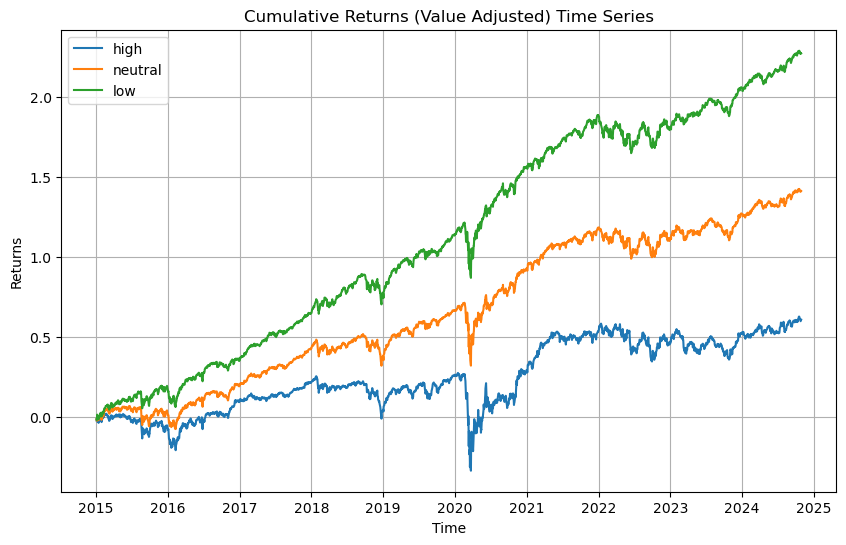

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(value_portfolio_returns.cumsum(), label=value_portfolio_returns.columns, alpha=1)

# Config
plt.title('Cumulative Returns (Value Adjusted) Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [61]:
# Create DataFrames

value_portfolio_betas = value_decomposition(betas_df, mktcap_df, ptb_df)

value_portfolio_betas

,high,neutral,low
2016-01-06,0.934933,0.963117,1.015449
2016-01-07,0.946094,0.963976,1.008184
2016-01-08,0.946969,0.963768,1.008334
2016-01-11,0.945199,0.962707,1.008671
2016-01-12,0.940421,0.962248,1.005820
...,...,...,...
2024-10-21,0.908102,0.745615,0.680435
2024-10-22,0.907601,0.742266,0.677052
2024-10-23,0.905637,0.737669,0.670431
2024-10-24,0.905539,0.736418,0.668628


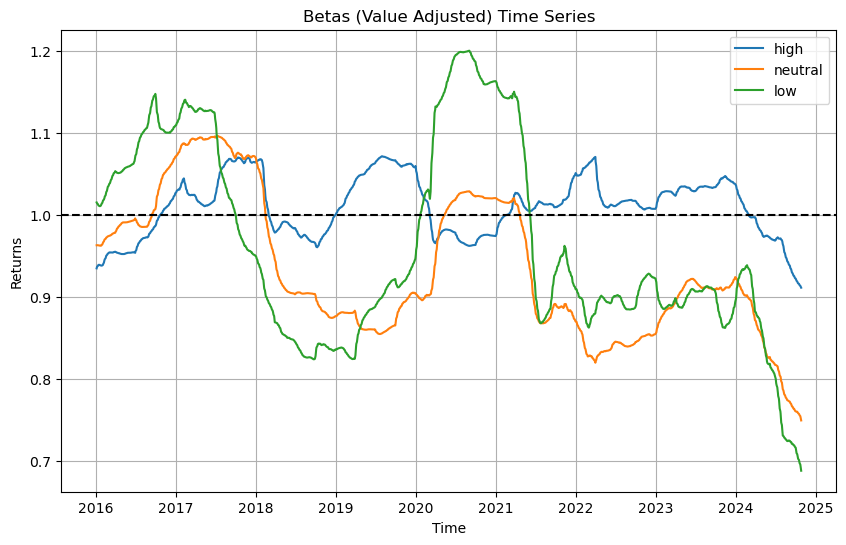

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(value_portfolio_betas.ewm(span=21, adjust = False).mean(), label=value_portfolio_betas.columns, alpha=1)
plt.axhline(y=1, color='black', linestyle='dashed')

# Config
plt.title('Betas (Value Adjusted) Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [63]:
# Create the regression dataframe
value_regression_df = pd.DataFrame(index = value_portfolio_returns.index)

value_regression_df['high_excess_returns'] = value_portfolio_returns['high'] - daily_rfr
value_regression_df['neutral_excess_returns'] = value_portfolio_returns['neutral'] - daily_rfr
value_regression_df['low_excess_returns'] = value_portfolio_returns['low'] - daily_rfr
value_regression_df['market_excess_returns'] = market_excess_returns
value_regression_df.dropna(inplace = True)

value_regression_df

,high_excess_returns,neutral_excess_returns,low_excess_returns,market_excess_returns
Date,,,,
2015-01-05,-0.019920,-0.016201,-0.012610,-0.018334
2015-01-06,-0.009946,-0.009546,-0.008953,-0.008948
2015-01-07,0.011318,0.012035,0.015110,0.011576
2015-01-08,0.016346,0.018972,0.018816,0.017832
2015-01-09,-0.008224,-0.007207,-0.007256,-0.008458
...,...,...,...,...
2024-10-22,-0.002443,-0.005634,-0.005368,-0.000589
2024-10-23,-0.000865,-0.002669,-0.006599,-0.009307
2024-10-24,-0.002747,0.000509,0.002531,0.002031


In [64]:
# Calculate the Beta for the High Portfolio

y = value_regression_df['high_excess_returns']
x = value_regression_df['market_excess_returns']

# Calculate Weights
window = len(y)

#Model specification
results = capm_regression(
    y,
    x,
    window,
    True
)
    
#here we check the summary
print(results.summary())

                             WLS Regression Results                            
Dep. Variable:     high_excess_returns   R-squared:                       0.722
Model:                             WLS   Adj. R-squared:                  0.722
Method:                  Least Squares   F-statistic:                     6368.
Date:                 Mon, 21 Apr 2025   Prob (F-statistic):               0.00
Time:                         16:23:12   Log-Likelihood:                 8563.1
No. Observations:                 2454   AIC:                        -1.712e+04
Df Residuals:                     2452   BIC:                        -1.711e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

In [65]:
# Calculate the Beta for the Neutral Portfolio

y = value_regression_df['neutral_excess_returns']
x = value_regression_df['market_excess_returns']

# Calculate Weights
window = len(y)

#Model specification
results = capm_regression(
    y,
    x,
    window,
    True
)
    
#here we check the summary
print(results.summary()) 

                              WLS Regression Results                              
Dep. Variable:     neutral_excess_returns   R-squared:                       0.908
Model:                                WLS   Adj. R-squared:                  0.908
Method:                     Least Squares   F-statistic:                 2.413e+04
Date:                    Mon, 21 Apr 2025   Prob (F-statistic):               0.00
Time:                            16:23:27   Log-Likelihood:                 10387.
No. Observations:                    2454   AIC:                        -2.077e+04
Df Residuals:                        2452   BIC:                        -2.076e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [66]:
# Calculate the Beta for the Low Portfolio

y = value_regression_df['low_excess_returns']
x = value_regression_df['market_excess_returns']

# Calculate Weights
window = len(y)

#Model specification
results = capm_regression(
    y,
    x,
    window,
    True
)
    
#here we check the summary
print(results.summary())  

                            WLS Regression Results                            
Dep. Variable:     low_excess_returns   R-squared:                       0.936
Model:                            WLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 3.592e+04
Date:                Mon, 21 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:23:39   Log-Likelihood:                 10743.
No. Observations:                2454   AIC:                        -2.148e+04
Df Residuals:                    2452   BIC:                        -2.147e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.00

In [67]:
# Calculate the Small Minus Big Premium

value_regression_df['HML'] = value_regression_df['high_excess_returns'] - value_regression_df['low_excess_returns']

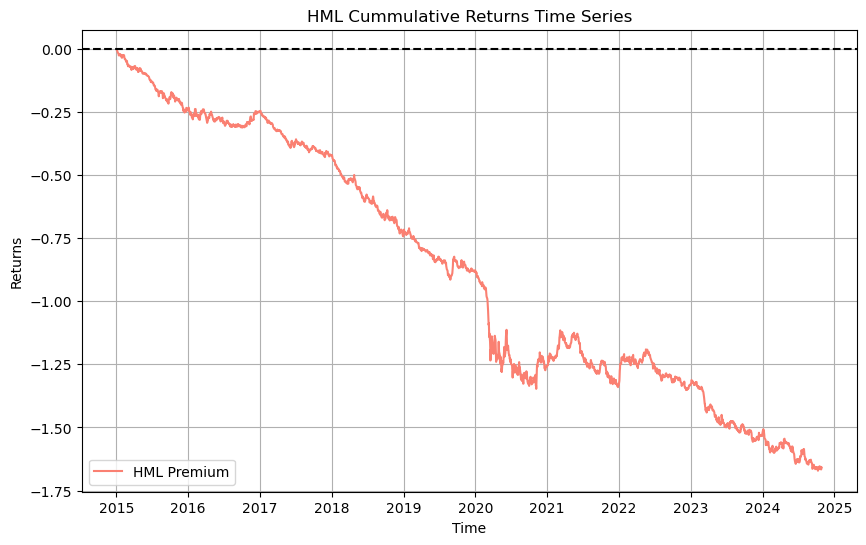

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(value_regression_df['HML'].cumsum(), label='HML Premium', color = 'salmon', alpha=1)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('HML Cumulative Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [69]:
# Check the Correlation with the Market

value_regression_df['HML'].corr(value_regression_df['market_excess_returns'])

0.06410726063611909

In [70]:
# Calculate the Beta for the HML Premium

y = value_regression_df['HML']
x = value_regression_df['market_excess_returns']

# Calculate Weights
window = len(y)

#Model specification
results = capm_regression(
    y,
    x,
    window,
    True
)
    
#here we check the summary
print(results.summary())  

                            WLS Regression Results                            
Dep. Variable:                    HML   R-squared:                       0.001
Model:                            WLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.849
Date:                Mon, 21 Apr 2025   Prob (F-statistic):             0.0916
Time:                        16:24:28   Log-Likelihood:                 8364.5
No. Observations:                2454   AIC:                        -1.673e+04
Df Residuals:                    2452   BIC:                        -1.671e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

### Collinearity among factors ###

In [71]:
value_regression_df['HML'].corr(size_regression_df['SMB'])

0.5830408894233514

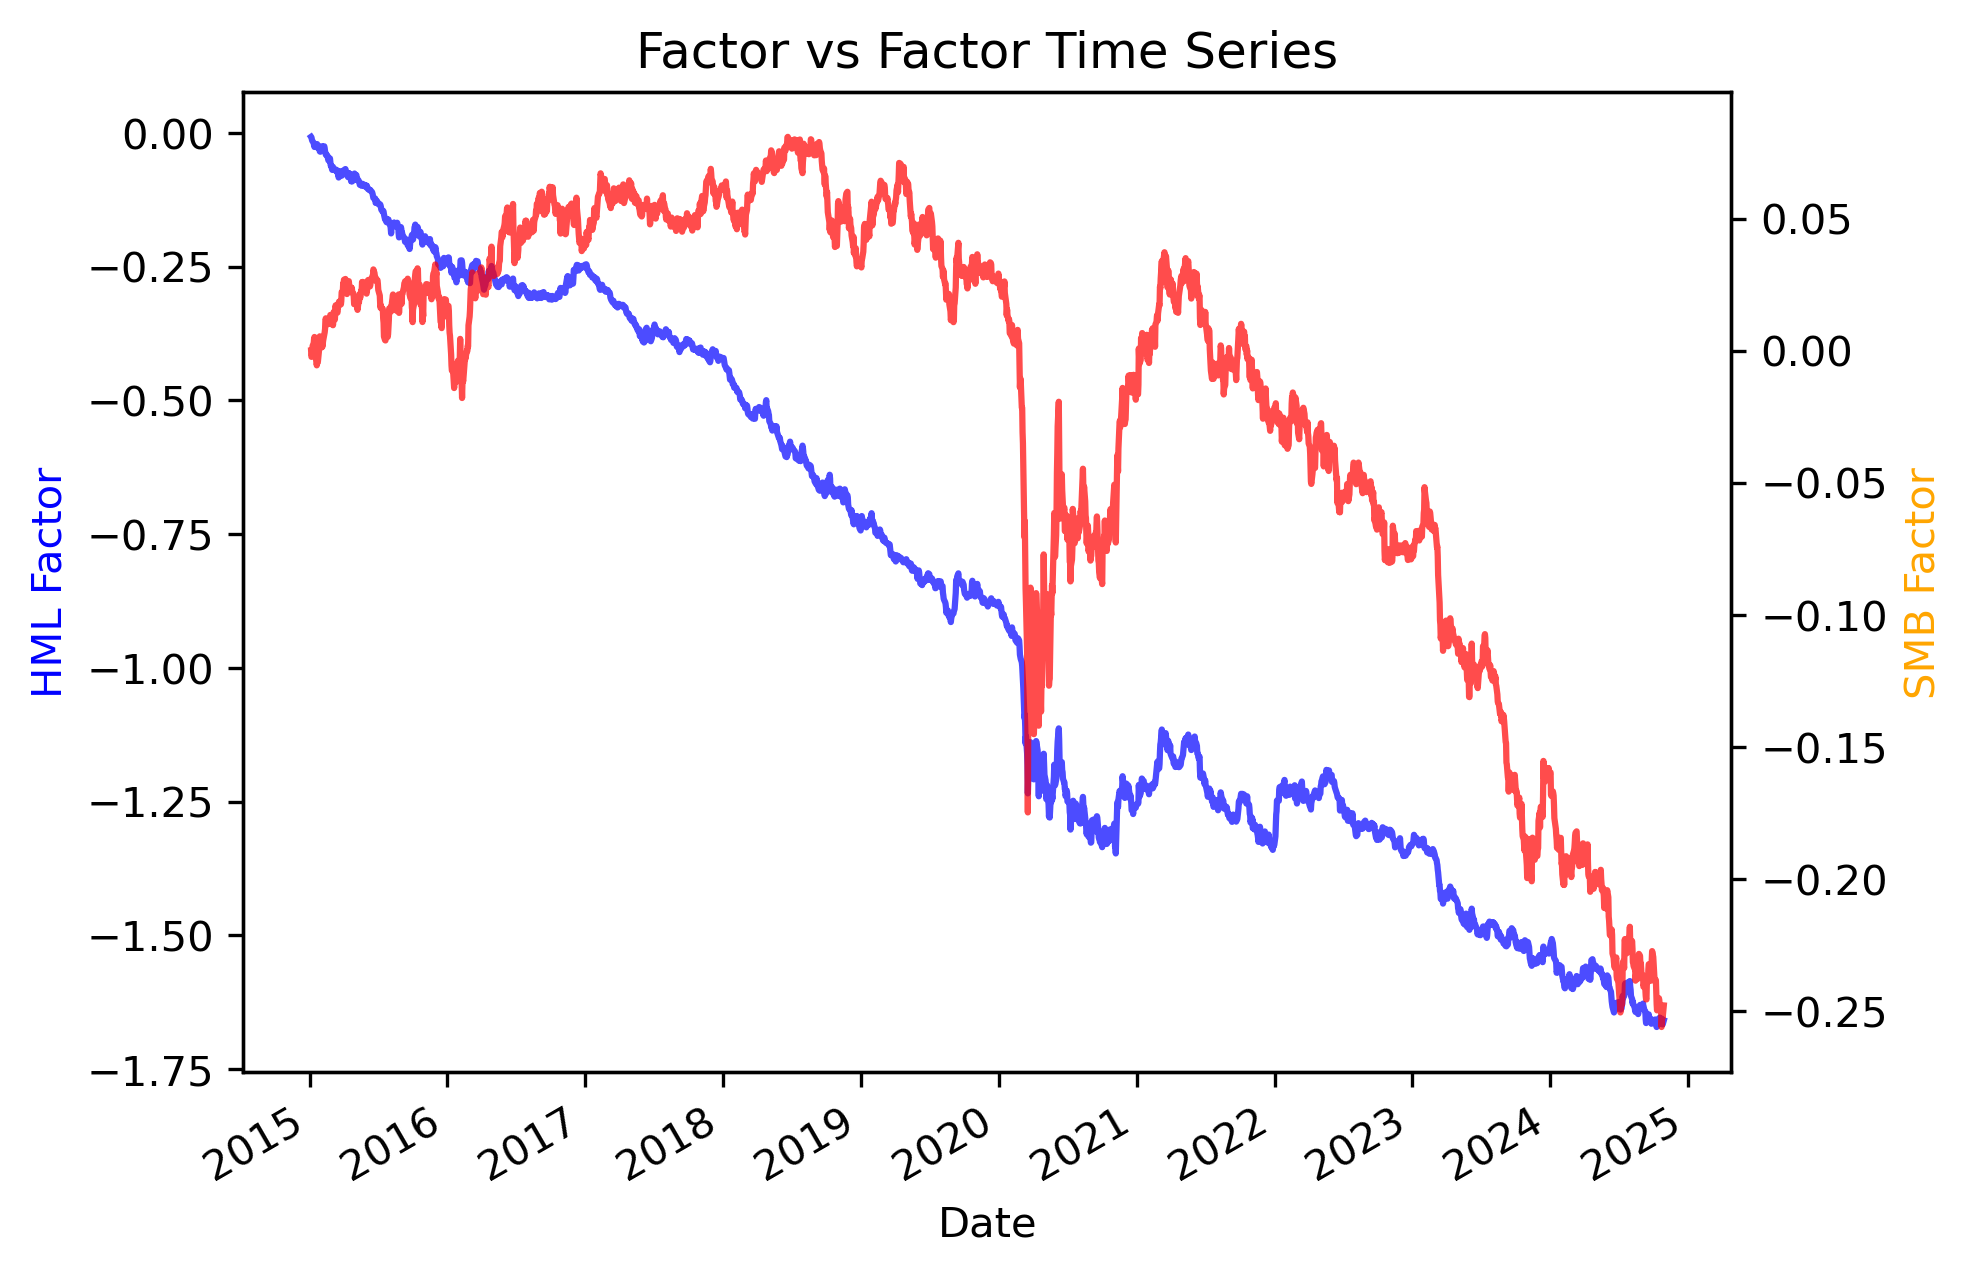

In [72]:
# Create Figure
fig, ax1 = plt.subplots(dpi = 300)

# Market Returns Plot
value_regression_df['HML'].cumsum().plot(color = 'blue', ax = ax1, alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel(
    'HML Factor', 
    color='blue'
    )

# ZBP Returns Plot
ax2 = ax1.twinx()

size_regression_df['SMB'].cumsum().plot(color = 'red', ax = ax2, alpha=0.7)
ax2.set_ylabel(
    'SMB Factor', 
    color='orange'
    )

plt.title('Factor vs Factor Time Series')
plt.show()

In [77]:
df_premiums = pd.DataFrame()

df_premiums['HML'] = value_regression_df['HML'].cumsum()
df_premiums['SMB'] = size_regression_df['SMB'].cumsum()

df_premiums

,HML,SMB
Date,,
2015-01-05,-0.007310,0.000091
2015-01-06,-0.008303,-0.002330
2015-01-07,-0.012095,-0.002189
2015-01-08,-0.014565,-0.000077
2015-01-09,-0.015533,0.001799
...,...,...
2024-10-22,-1.661508,-0.255951
2024-10-23,-1.655775,-0.254030
2024-10-24,-1.661052,-0.251645


In [78]:
premiums_analytics = calculate_analytics(df_premiums)

premiums_analytics

,Annualized Returns,Annualized Volatility,Sharpe Ratio,Max Drawdown,VaR 95%
HML,-222.100371,7.941540,-27.966913,-1.000000,-1.585643
SMB,-4.890225,1.351512,-3.618337,-0.636984,-0.200489
